In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import sklearn
import scipy
import torch
import torchvision
import os
%matplotlib inline 

In [2]:
#Take sales of only one product for now
pd_bookstock= pd.read_csv('dataset_2019_01_24.csv')

df_p = pd_bookstock[pd_bookstock['base_product_number']==54046134]
#print(df_p)

In [3]:
print(df_p.columns) #copy-pasting column names from here to groupby() functions avoids KeyErrors

Index(['retail_outlet_number', 'base_product_number', 'calendar_date',
       'calendar_hour', 'stock_count_shelf', 'stock_count_backroom',
       'book_stock_quantity', 'change', 'change_cause', 'min_bookstock',
       'max_bookstock', 'calculated_bookstock', 'change_cause_grouped'],
      dtype='object')


In [17]:
#Take only entries that have change_cause as 'sales'
sales_df_p = df_p[df_p['change_cause']=='sales'].reset_index()
#print(sales_df_p)

#sum up all sales within a particular day for all days. This gives per day sales for product 54046134 for all days
# Note that the total data for this product is for 142 days
sum_change = sales_df_p.groupby('calendar_date')['change'].sum().reset_index()
max_calcbk = sales_df_p.groupby('calendar_date')['calculated_bookstock'].min().reset_index()
#print(sum_change)
#print(max_calcbk)
#sum_change['max_calcbk'] = max_calcbk['calculated_bookstock'] #add a new column named 'max_calcbk'
sum_change['change'] = sum_change['change']*-1

##################################################
#Additional info:
size_days = np.size(sum_change['calendar_date'])
mean_sales = sum_change['change'].mean()*-1
print("Total number of days of sales data:", size_days)
print("Average number of sales per day:",mean_sales) #calculating average sales per day
###################################################

#rename the column from 'change' to 'sales'
sum_change.rename(columns={list(sum_change)[1]:"sales"}, inplace = True) # can successfully rename column here

#sum_change.head(71)
size_days_half = np.size(sum_change['calendar_date'])/2

#print(sum_change.head(71))
#print(sum_change.tail(71))
print(sum_change)

training_dt = sum_change.head(71) #create the training dataset of upper half entries
testing_dt = sum_change.tail(71) #testing dataset of bottom half entries

#CREATE LABELS for all sales numbers
all_labels=[]
for a in range(np.size(sum_change['sales'])):
    if(sum_change['sales'][a]<5):
        all_labels.append('0')
    else:
        all_labels.append('1')

#print(all_labels)

Total number of days of sales data: 142
Average number of sales per day: -4.887323943661972
    calendar_date  sales
0      01/06/2018      9
1      01/07/2018      2
2      01/09/2018      5
3      01/10/2018      5
4      02/06/2018      9
5      02/09/2018      2
6      02/10/2018     10
7      03/06/2018      8
8      03/07/2018      4
9      03/08/2018      2
10     03/09/2018      5
11     03/10/2018      4
12     04/06/2018      3
13     04/07/2018      4
14     04/08/2018      6
15     04/09/2018      6
16     04/10/2018     11
17     05/06/2018      7
18     05/07/2018      4
19     05/08/2018      2
20     05/10/2018      9
21     06/06/2018     10
22     06/07/2018     10
23     06/08/2018      2
24     06/09/2018      1
25     06/10/2018      5
26     07/06/2018      1
27     07/07/2018      3
28     07/08/2018      9
29     07/09/2018      6
..            ...    ...
112    24/10/2018      2
113    25/06/2018      1
114    25/07/2018      2
115    25/08/2018      6
116    2

In [5]:
print("Total number of days of sales data:",size_days)
#sum_change[:75] #accessing the first 75 entries of table sum_change
#print(sum_change['change']) #accessing the column
print(sum_change['sales'][0]) #accessing a column value by its index

#Create training set
training_set_less = []
training_set_more = []
labels = []

for a in range(np.size(training_dt['calendar_date'])):
    if(training_dt['sales'][a]<5):
#        print(training_dt['sales'][a], training_dt['max_calcbk'][a])
        training_set_less.append((training_dt['sales'][a], training_dt['max_calcbk'][a]))
        labels.append('0')

for a in range(np.size(training_dt['calendar_date'])):
    if(training_dt['sales'][a]>=5):
#        print(training_dt['sales'][a], training_dt['max_calcbk'][a])
        training_set_more.append((training_dt['sales'][a], training_dt['max_calcbk'][a]))
        labels.append('1')

training_set_less = np.asarray(training_set_less)
training_set_more = np.asarray(training_set_more)
labels = np.asarray(labels)

#print(training_set_less)
#print(training_set_more)
#print(labels)
    

Total number of days of sales data: 142
9


In [6]:
#plt.figure(figsize=(10, 10))

#print(training_set_less[:,:2]) access 2nd column
#print(np.size(training_set_more[:,:1]))
#print(training_set_less[:,0])
#print(training_set_less)

#plt.scatter(training_set_less[:,0], training_set_less[:,1], color='b', label='0')
#plt.scatter(training_set_more[:,0], training_set_more[:,1], color='r', label='1')
#plt.legend();

In [7]:
pd_bookstock.columns

Index(['retail_outlet_number', 'base_product_number', 'calendar_date',
       'calendar_hour', 'stock_count_shelf', 'stock_count_backroom',
       'book_stock_quantity', 'change', 'change_cause', 'min_bookstock',
       'max_bookstock', 'calculated_bookstock', 'change_cause_grouped'],
      dtype='object')

In [8]:
#pd_bookstock['calendar_date'] #workds
pd_bookstock.groupby('calendar_date')

### semi-final preparation of data

In [9]:
print("Total number of days of sales data in main dataframe:",size_days)
#sum_change[:75] #accessing the first 75 entries of table sum_change
#print(sum_change['change']) #accessing the column
print(training_dt['sales'][0]) #accessing a column value by its index

#Create training set
training_set_less = []
training_set_more = []
labels = []

for a in range(np.size(training_dt['calendar_date'])):
    if(training_dt['sales'][a]<5):
#        print(sum_change['sales'][a], sum_change['max_calcbk'][a])
        training_set_less.append((training_dt['sales'][a], '0'))
        labels.append('0')

for a in range(np.size(training_dt['calendar_date'])):
    if(training_dt['sales'][a]>=5):
#        print(sum_change['sales'][a], sum_change['max_calcbk'][a])
        training_set_more.append((training_dt['sales'][a], '1'))
        labels.append('1')

training_set_less = np.asarray(training_set_less)
training_set_more = np.asarray(training_set_more)
labels = np.asarray(labels)
#######################################################################

#######################################################################
#TESTING SET

testingdt_sales_values= testing_dt['sales'].values
print(testingdt_sales_values)

Total number of days of sales data in main dataframe: 142
9
[ 4  3 13  2  9  2  4  4  1  6  2  7  5  4  9  1 13 12  1  5  2 13  3  4
  3  3  5  5  1  9  6 11  5  2  5  4  3  6  3  7  3  2  1  2  6  6  6  3
  6  5  4  5  2  6  3  4  4  9  4  2  2  4  6  5  2  6  5  3  2  5  3]


### visualizing the data

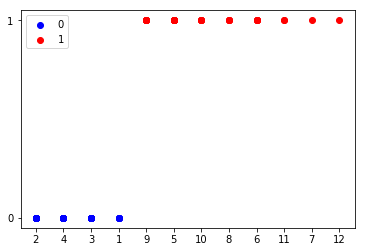

In [10]:
plt.scatter(training_set_less[:,0], training_set_less[:,1], color='b', label='0')
plt.scatter(training_set_more[:,0], training_set_more[:,1], color='r', label='1')
plt.legend();

### final preparation of the data and labels

In [11]:
from sklearn.linear_model import LogisticRegression

joint_training = np.concatenate((training_set_less, training_set_more), axis=0) #join both arrays
training_data=joint_training[:,0] #this is the training data
training_labels=joint_training[:,1] #the corresponding labels
print(training_data)
print(training_labels)
#print(np.size(data))
#print(data[:,None])

['2' '2' '4' '2' '4' '3' '4' '4' '2' '2' '1' '1' '3' '2' '3' '2' '3' '2'
 '2' '4' '3' '4' '3' '3' '4' '4' '2' '3' '1' '3' '3' '2' '1' '4' '4' '4'
 '1' '4' '9' '5' '5' '9' '10' '8' '5' '6' '6' '11' '7' '9' '10' '10' '5'
 '9' '6' '11' '12' '5' '5' '8' '5' '9' '10' '9' '8' '9' '10' '5' '8' '6'
 '6']
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


### fitting the model to labels

In [12]:
model = LogisticRegression(C=1e20) #C is the inverse of regularization
#print(model)

#Fit the training data to the labels
%time model.fit(training_data[:,None], training_labels)  #supply data in the form of a 2D array "data[:,None]" to fit(). 1D array gives an error

CPU times: user 5.44 ms, sys: 5.87 ms, total: 11.3 ms
Wall time: 22.5 ms


/Users/Ganesh/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### testing the model

In [13]:
print(testingdt_sales_values)

pred_labels = model.predict(testingdt_sales_values[:,None])
print(pred_labels)
#model.predict(testingdt_sales_values[:,None])[0:5]

[ 4  3 13  2  9  2  4  4  1  6  2  7  5  4  9  1 13 12  1  5  2 13  3  4
  3  3  5  5  1  9  6 11  5  2  5  4  3  6  3  7  3  2  1  2  6  6  6  3
  6  5  4  5  2  6  3  4  4  9  4  2  2  4  6  5  2  6  5  3  2  5  3]
['0' '0' '1' '0' '1' '0' '0' '0' '0' '1' '0' '1' '1' '0' '1' '0' '1' '1'
 '0' '1' '0' '1' '0' '0' '0' '0' '1' '1' '0' '1' '1' '1' '1' '0' '1' '0'
 '0' '1' '0' '1' '0' '0' '0' '0' '1' '1' '1' '0' '1' '1' '0' '1' '0' '1'
 '0' '0' '0' '1' '0' '0' '0' '0' '1' '1' '0' '1' '1' '0' '0' '1' '0']


In [14]:
#the intercept in logistic regression is log of the odds value (remember the StatQuest video) on the Y-axis when
#...the corresponding x-value is 0

model.intercept_, model.coef_

#The coefficients are represented in terms of log(odds) graph (from StatQuest video on coefficients)

(array([-74.00621403]), array([[16.41247646]]))

### Confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

pred_labels = model.predict(testingdt_sales_values[:,None])

#print(confusion_matrix(training_labels, pred_labels))
print(confusion_matrix(pred_labels, training_labels))

print(classification_report(pred_labels, training_labels))

[[20 19]
 [18 14]]
              precision    recall  f1-score   support

           0       0.53      0.51      0.52        39
           1       0.42      0.44      0.43        32

   micro avg       0.48      0.48      0.48        71
   macro avg       0.48      0.48      0.48        71
weighted avg       0.48      0.48      0.48        71



**Accuracy** = (TP + TN) /(TP + TN + FP + FN)

**Precision** = (TP) / (TP + FP)

**Recall** = (TP) / (TP + FN)

**F1 Score** = (2 x Precision x Recall) / (Precision + Recall)

### random_state

If you use random_state=some_number, then you can guarantee that the output of Run 1 will be equal to the output of Run 2, i.e. your split will be always the same. It doesn't matter what the actual random_state number is 42, 0, 21, ... The important thing is that everytime you use 42, you will always get the same output the first time you make the split. This is useful if you want reproducible results, for example in the documentation, so that everybody can consistently see the same numbers when they run the examples. In practice I would say, you should set the random_state to some fixed number while you test stuff, but then remove it in production if you really need a random (and not a fixed) split.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sum_change['sales'].values, all_labels, test_size = 0.3, random_state = 42, shuffle = True)

y_pred = model.predict (X_test[:,None])
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[25  0]
 [ 0 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        18

   micro avg       1.00      1.00      1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

